# 1.0 Working on Signature Methods

In [1]:
from clustergrammer_widget import *
net = Network(clustergrammer_widget)
df = {}

import clustergrammer_groupby as cby
import gene_exp_10x

In [2]:
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline 

### Load Default Dataset

In [3]:
net.load_file('../data/rc_two_cats.txt')
df['ini'] = net.export_df()
df['ini'].shape

### Drop Gender Category
cols = df['ini'].columns.tolist()
new_cols = []
for inst_col in cols:
    inst_col = list(inst_col)
    new_col = tuple(inst_col[:2])
    new_cols.append(new_col)

df['ini'].columns = new_cols

### Make Dataset with no categories

In [4]:
df['no_cat'] = deepcopy(df['ini'])
cols = df['no_cat'].columns.tolist()
new_cols = []
for inst_col in cols:
    new_col = inst_col[0]
    new_cols.append(new_col)
df['no_cat'].columns = new_cols

In [5]:
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: one', inst_color='red')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: two', inst_color='blue')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: three', inst_color='yellow')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: four', inst_color='black')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: five', inst_color='purple')

# Visualize Original Dataset

In [6]:
net.load_df(df['ini'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [7]:
max_cl = df['ini'].idxmax(axis=1)

In [8]:
max_cl

(Gene: CDK4, Gene Type: Interesting)             (Cell Line: HCC827, Category: one)
(Gene: LMTK3, Gene Type: Not Interesting)       (Cell Line: CAL-12T, Category: two)
(Gene: LRRK2, Gene Type: Not Interesting)       (Cell Line: H1944, Category: three)
(Gene: UHMK1, Gene Type: Not Interesting)       (Cell Line: H1944, Category: three)
(Gene: EGFR, Gene Type: Interesting)             (Cell Line: HCC827, Category: one)
(Gene: STK32A, Gene Type: Interesting)           (Cell Line: HCC78, Category: five)
(Gene: NRK, Gene Type: Interesting)              (Cell Line: HCC827, Category: one)
(Gene: ERBB2, Gene Type: Not Interesting)       (Cell Line: CALU-3, Category: four)
(Gene: ERBB4, Gene Type: Not Interesting)         (Cell Line: H661, Category: five)
(Gene: AAK1, Gene Type: Not Interesting)          (Cell Line: H1650, Category: two)
(Gene: SRPK3, Gene Type: Not Interesting)        (Cell Line: H2106, Category: four)
(Gene: STK39, Gene Type: Interesting)           (Cell Line: CALU-3, Category

# Run with True Categories

In [192]:
from sklearn.metrics import pairwise_distances
def predict_cats_from_sigs(df_data_ini, df_sig, dist_type='cosine', predict_level='Predict Category',
                           truth_level=1):
    ''' Predict category using signature '''

    keep_rows = df_sig.index.tolist()
    df_data = deepcopy(df_data_ini.ix[keep_rows])

    # calculate sim_mat of df_data and df_sig
    cell_types = df_sig.columns.tolist()
    barcodes = df_data.columns.tolist()
    sim_mat = 1 - pairwise_distances(df_sig.transpose(), df_data.transpose(), metric=dist_type)
    df_sim = pd.DataFrame(data=sim_mat, index=cell_types, columns=barcodes).transpose()


    # get the top column value (most similar signature)
    df_sim_top = df_sim.idxmax(axis=1)
    
    
    # add predicted category name to top list
    top_list = df_sim_top.get_values()
    top_list = [ predict_level + ': ' + x[0] for x in top_list]    

    # add cell type category to input data
    df_cat = deepcopy(df_data)
    cols = df_cat.columns.tolist()
    new_cols = []
    
    # check whether the columns have the true category available
    has_truth = False
    if type(cols[0]) is tuple:
        has_truth = True
    
    print(top_list)
    print('**********************')
    print(cols)
    
    if has_truth:
        new_cols = [tuple(list(a) + [b]) for a,b in zip(cols, top_list)]
    else:
        new_cols = [tuple([a] + [b]) for a,b in zip(cols, top_list)]
    
    print('***************************************')
    print(new_cols)
    
#     for i in range(len(cols)):

#         if has_truth:
#             inst_col = list(cols[i])
#             inst_col.append(top_list[i])
#             new_col = tuple(inst_col)
#         else:
#             inst_col = cols[i]
#             new_col = (inst_col, top_list[i])

#         new_cols.append(new_col)

    # transfer new categories
    df_cat.columns = new_cols
    
    
    # keep track of true and predicted labels
    y_info = {}
    y_info['true'] = []
    y_info['pred'] = []
    
    if has_truth:
        y_info['true'] = [x[truth_level].split(': ')[1] for x in cols]
        y_info['pred'] = [x.split(': ')[1] for x in top_list]



    return df_cat, df_sim.transpose(), df_sim.transpose(), y_info

In [193]:
df['cat_sig'], keep_genes, keep_genes_dict = cby.generate_signatures(df['ini'], 'Category', pval_cutoff=0.05)
df['pred_cat'], df['sig_sim'], df['sig_max'], y_info = predict_cats_from_sigs(df['ini'], df['cat_sig'])
df['conf'], true_count, pred_count, ser_correct, fraction_correct = cby.confusion_matrix_and_correct_series(y_info)
print(fraction_correct)

['Predict Category: five', 'Predict Category: two', 'Predict Category: two', 'Predict Category: one', 'Predict Category: two', 'Predict Category: two', 'Predict Category: three', 'Predict Category: one', 'Predict Category: five', 'Predict Category: five', 'Predict Category: four', 'Predict Category: five', 'Predict Category: two', 'Predict Category: five', 'Predict Category: five', 'Predict Category: one', 'Predict Category: one', 'Predict Category: three', 'Predict Category: three', 'Predict Category: three', 'Predict Category: four', 'Predict Category: one', 'Predict Category: three', 'Predict Category: four', 'Predict Category: one', 'Predict Category: five', 'Predict Category: four', 'Predict Category: three', 'Predict Category: one']
**********************
[('Cell Line: H1650', 'Category: two'), ('Cell Line: H23', 'Category: two'), ('Cell Line: CAL-12T', 'Category: two'), ('Cell Line: H358', 'Category: one'), ('Cell Line: H1975', 'Category: two'), ('Cell Line: HCC15', 'Category: t

# Run with no True categories

In [194]:
# df['cat_sig'], keep_genes, keep_genes_dict = cby.generate_signatures(df['ini'], 'Category')
# df['pred_cat'], df['sig_sim'], df['sig_max'], y_info = cby.predict_cats_from_sigs(df['no_cat'], df['cat_sig'])

# Category Signature

In [195]:
net.load_df(df['cat_sig'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


### Visualize Informative Dimensions in Original Data
Generate a matrix with only category-informative dimensions/genes.

In [196]:
net.load_df(df['ini'].ix[keep_genes])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


# Predict Category Based on Signature

In [197]:
net.load_df(df['pred_cat'])
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: one', inst_color='red')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: two', inst_color='blue')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: three', inst_color='yellow')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: four', inst_color='black')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: five', inst_color='purple')

In [198]:
net.load_df(df['pred_cat'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [199]:
net.load_df(df['sig_sim'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [200]:
net.load_df(df['sig_max'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


### F1 Scores

In [201]:
print(f1_score(y_info['true'], y_info['pred'], average='macro'))
print(f1_score(y_info['true'], y_info['pred'], average='micro'))
print(f1_score(y_info['true'], y_info['pred'], average='weighted'))

0.825734265734
0.827586206897
0.820352061731


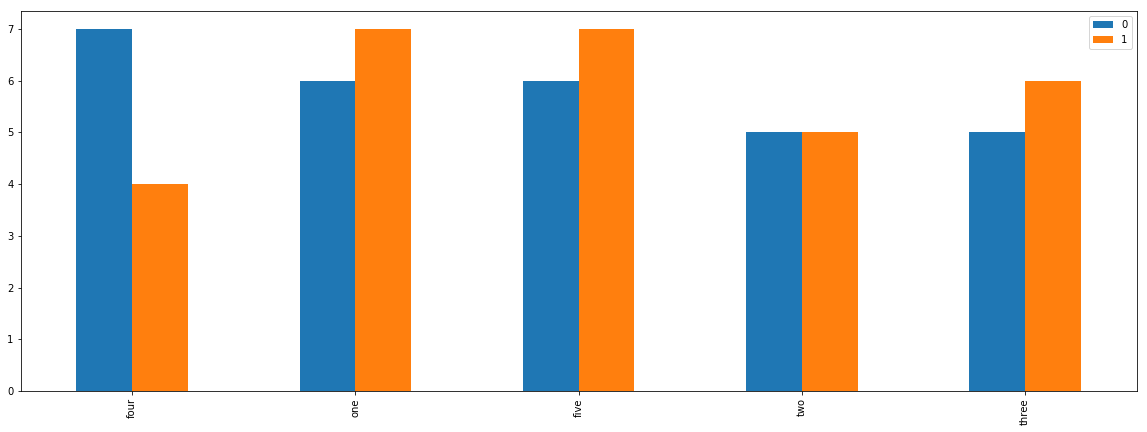

In [202]:
ser_orig_pop = pd.Series(true_count).sort_values(ascending=False)
ser_pred_pop = pd.Series(pred_count).sort_values(ascending=False)
df['compare_pop'] = pd.concat([ser_orig_pop, ser_pred_pop], axis=1)
df['compare_pop'] = df['compare_pop'].loc[ser_orig_pop.index.tolist()]
df['compare_pop'].plot(kind='bar', figsize=(20,7))

### Visualize confusion matrix

In [203]:
net.load_df(df['conf'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [204]:
real_fraction_correct = deepcopy(fraction_correct)

### Calculate the fraction of correct predictions for each category type

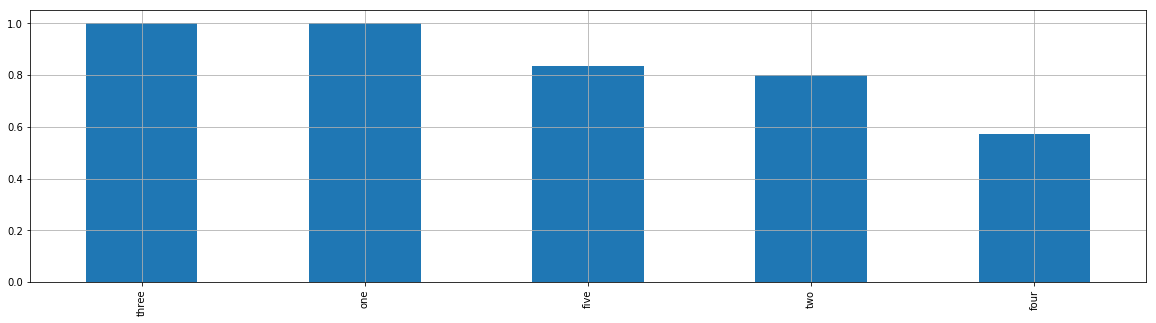

In [205]:
ser_correct.sort_values(ascending=False).plot(kind='bar', figsize=(20,5), grid=True)

# Shuffle Labels and Predict Categories
Run 

In [206]:
num_shuffles = 100
perform_ser = cby.compare_performance_to_shuffled_labels(df['ini'], df['cat_sig'], 'Category', 
                                                         num_shuffles=num_shuffles)
print('mean: ', perform_ser.mean(), 'std: ', perform_ser.std())
print('previously calc real performance: ', real_fraction_correct)

performance (fraction correct) of unshuffled: 0.827586206897
mean:  0.646206896552 std:  0.0964944847001
previously calc real performance:  0.827586206897


In [207]:
real_performance = perform_ser[perform_ser > real_fraction_correct].shape[0]/num_shuffles
print('real labels perform in the top ' + str(real_performance*100) + '% of shuffled labels')

real labels perform in the top 3.0% of shuffled labels


### Example Shuffled Dataset

In [24]:
# net.load_df(df['shuffle'])
# net.cluster()
# net.widget()